In [14]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# load modules related to this exercise
from TwoAssetModel import TwoAssetModelClass 
import estimate

import numba as nb
nb.set_num_threads(8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model

In [15]:
model = TwoAssetModelClass(
    name='example_negm',
    par={
        'solmethod':'negm',
        'T':15, # shorten the life cycle
        'Tmin':0,
        'Tr':10,
        'moments_numsim':25,
        'do_print':False
        })
model.precompile_numba() # solve with very coarse grids
model.solve()
model.simulate()

par = model.par
sol = model.sol
sim = model.sim

## Data / obtaining the empirical moments for a and y

In [4]:
# read data from statistikbanken
df_y = pd.read_excel('data/y.xlsx',sheet_name='y',header=0)
df_a = pd.read_excel('data/a.xlsx',sheet_name='a',header=0)

#interpolating between age intervals
df_y = df_y.interpolate(method='linear',axis=0)
df_a = df_a.interpolate(method='linear',axis=0)

for df in [df_y,df_a]:
    df.rename(columns={'Unnamed: 0': 'age'}, inplace=True)

#dropping unnecessary rows/cols
mask = df_a.age.isin(range(18,25))
df_a = df_a.loc[~mask].copy(deep=True)

#to np array
y = df_y.drop(columns='age').to_numpy().mean(axis=1)
a = df_a.drop(columns='age').to_numpy().mean(axis=1)

# join into one 56x2 array
mean_data = np.array([a,y])#[:,:30]

## MOMENTS USING MEAN FOR a AND y

In [5]:
# save true parameters
par_beta = copy.copy(par.beta)
par_rho = copy.copy(par.rho)

# data / empirical moments
data = copy.copy(sim)
data.moments = estimate.calc_moments(par,data)   # replace this with 
#data.moments = mean_data  # replace this with 
#scale_y = model.sim.y.mean()/mean_data[:,1].mean()  
#data.moments *= scale_y # scale empirical moments to be of similar scale as simulated moments


In [9]:
count = 1
for i in range(Nbeta):
    for j in range(Nrho):
        print(f"{count} / {Nbeta*Nrho}: beta={beta[i]}, rho={rho[j]}")
        count+=1

1 / 25: beta=0.955, rho=1.8
2 / 25: beta=0.955, rho=1.9000000000000001
3 / 25: beta=0.955, rho=2.0
4 / 25: beta=0.955, rho=2.1
5 / 25: beta=0.955, rho=2.2
6 / 25: beta=0.96, rho=1.8
7 / 25: beta=0.96, rho=1.9000000000000001
8 / 25: beta=0.96, rho=2.0
9 / 25: beta=0.96, rho=2.1
10 / 25: beta=0.96, rho=2.2
11 / 25: beta=0.965, rho=1.8
12 / 25: beta=0.965, rho=1.9000000000000001
13 / 25: beta=0.965, rho=2.0
14 / 25: beta=0.965, rho=2.1
15 / 25: beta=0.965, rho=2.2
16 / 25: beta=0.97, rho=1.8
17 / 25: beta=0.97, rho=1.9000000000000001
18 / 25: beta=0.97, rho=2.0
19 / 25: beta=0.97, rho=2.1
20 / 25: beta=0.97, rho=2.2
21 / 25: beta=0.975, rho=1.8
22 / 25: beta=0.975, rho=1.9000000000000001
23 / 25: beta=0.975, rho=2.0
24 / 25: beta=0.975, rho=2.1
25 / 25: beta=0.975, rho=2.2


In [6]:
Nbeta = 5
Nrho = 5

obj = np.nan + np.zeros((Nbeta,Nrho))
beta = np.linspace(0.955,0.975,Nbeta)
rho = np.linspace(1.8,2.2,Nrho)

count = 1
for i in range(Nbeta):
    for j in range(Nrho):
        np.random.seed(1999)      
        print(f"{count} / {Nbeta*Nrho}")
        est_par = ['beta','rho']
        theta0 = [beta[i], rho[j]]
        obj[i,j]=estimate.sum_squared_diff_moments(theta0,model,est_par,data)
        count += 1


1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25


Traceback (most recent call last):
  File "/Users/frederikp/OneDrive - University of Copenhagen/Kandidat/Dynamic Programming/dp2022/two_asset/TwoAssetModel.py", line 308, in solve
    assert np.all((sol.q[t] > 0) & (np.isnan(sol.q[t]) == False)), t
AssertionError: 46


AssertionError: 46

In [13]:
obj

array([[32.49338938, 31.81182219, 31.07040279, 30.35719422, 29.62767446],
       [22.36455292, 21.97634126, 21.57056154, 21.12380587, 20.64247023],
       [12.39539992, 12.34001838, 12.25379523, 12.12259198, 11.9314645 ],
       [ 4.38715638,  4.60235609,  4.76258179,  4.88877717,  4.96867388],
       [ 1.72429983,         nan,         nan,         nan,         nan]])

/var/folders/d8/k9yj32vx0_76gfhvj06fhzzw0000gn/T/ipykernel_57658/1189883604.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf, shrink=0.5, aspect=5)


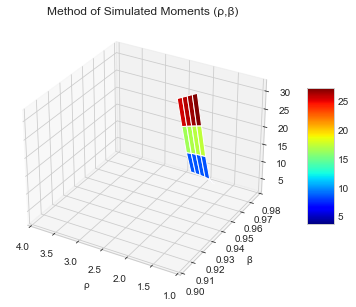

In [10]:
#Plot figure in three dimensions

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d')

# Make data.
X, Y = np.meshgrid(rho, beta)

# Plot the surface.
surf = ax.plot_surface(X, Y, obj, cmap=cm.jet)

# Customize the axis.
ax.set_xlabel(f'\u03C1')
ax.set_ylabel(f'\u03B2')
ax.set_title(f'Method of Simulated Moments (\u03C1,\u03B2)')
ax.set_xlim(1.0,4.0)
#ax.set_xlim(1.0,6.0)
ax.set_ylim(0.9,0.98)
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show();

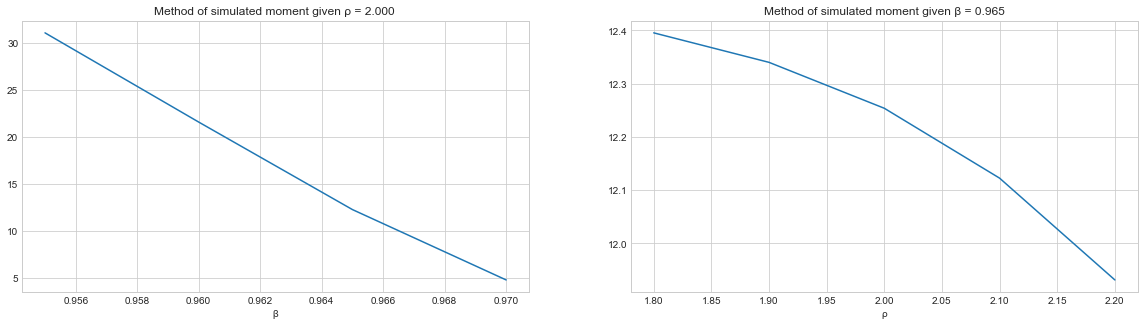

In [12]:
# Plot figure in two dimensions
i_rho = abs(par_rho - rho).argmin(0) #index of rho closest to true rho
i_beta = abs(par_beta - beta).argmin(0) #index of beta closest to true beta


fig = plt.figure(figsize=(20,5))# figsize is in inches...

ax = fig.add_subplot(1,2,1)
ax.plot(beta,obj[:,i_rho])
ax.set_xlabel(f'\u03B2')
ax.set_title(f'Method of simulated moment given \u03C1 = {rho[i_rho]:.3f} ')

ax = fig.add_subplot(1,2,2)
ax.plot(rho,obj[i_beta,:])
ax.set_xlabel(f'\u03C1')
ax.set_title(f'Method of simulated moment given \u03B2 = {beta[i_beta]:.3f}')


plt.show()

## Rest of notebook

In [27]:
est_par = ['beta'] # Parameter to estimate
theta0 = [0.94] # Initial guess

est = estimate.method_simulated_moments(model, est_par,theta0,data)

#Re-inset the true parameters 
par.beta = copy.copy(par_beta)

print(f'Objective:               {est.fun:.4f}')
print(f'beta:                    {est.x[0]:.4f}')
print(f'Number of iterations:    {est.nit}')


Traceback (most recent call last):
  File "/Users/frederikp/OneDrive - University of Copenhagen/Kandidat/Dynamic Programming/dp2022/praise_the_lord/DurableConsumptionModel.py", line 300, in solve
    post_decision.compute_wq(t,sol,par,compute_q=True)
KeyboardInterrupt


KeyboardInterrupt: 

In [11]:
est_par = ['rho'] # Parameter to estimate
theta0 = [2.5] # Initial guess

est = estimate.method_simulated_moments(model, est_par,theta0,data)

#Re-inset the true parameters 
par.rho = copy.copy(par_rho)

print(f'Objective:               {est.fun:.4f}')
print(f'rho:                     {est.x[0]:.4f}')
print(f'Number of iterartions:   {est.nit}')


Objective:               0.0420
rho:                     3.5721
Number of iterartions:   3


In [19]:
est_par = ['rho','beta'] # Parameters to estimate
theta0 = [4, 0.94] # Initial guesses

est = estimate.method_simulated_moments(model, est_par,theta0,data)

#Re-inset the true parameters 
par.beta = copy.copy(par_beta)
par.rho = copy.copy(par_rho)

print(f'Objective:               {est.fun:.4f}')
print(f'rho:                     {est.x[0]:.4f}')
print(f'beta:                    {est.x[1]:.4f}')
print(f'Number of iterartions:   {est.nit}')


Traceback (most recent call last):
  File "/Users/frederikp/OneDrive - University of Copenhagen/Kandidat/Dynamic Programming/dp2022/praise_the_lord/DurableConsumptionModel.py", line 298, in solve
    post_decision.compute_wq(t,sol,par,compute_q=True)
KeyboardInterrupt


KeyboardInterrupt: 

In [25]:
print(sol.c_keep)

[[[[0.00000000e+00 7.52277641e-03 1.25578236e-02 ... 5.88029677e-01
    6.04148591e-01 6.22278930e-01]
   [0.00000000e+00 9.63427940e-03 1.31550486e-02 ... 5.21084873e-01
    5.35308389e-01 5.51384575e-01]
   [0.00000000e+00 1.08564001e-02 1.44200450e-02 ... 4.99850422e-01
    5.13376724e-01 5.28812351e-01]
   ...
   [0.00000000e+00 6.37971512e-02 8.66043861e-02 ... 4.76802959e-01
    4.87017793e-01 4.98755681e-01]
   [0.00000000e+00 6.37971512e-02 8.99047165e-02 ... 4.79185517e-01
    4.89354122e-01 5.01077165e-01]
   [0.00000000e+00 6.37971512e-02 9.36833292e-02 ... 4.81912449e-01
    4.92130130e-01 5.03728006e-01]]

  [[0.00000000e+00 4.60810525e-02 5.81236948e-02 ... 6.63206118e-01
    6.79318421e-01 6.97934440e-01]
   [0.00000000e+00 4.72291869e-02 5.60625283e-02 ... 5.87526374e-01
    6.01819245e-01 6.18294714e-01]
   [0.00000000e+00 4.97980459e-02 5.68393941e-02 ... 5.63328276e-01
    5.77011334e-01 5.92759688e-01]
   ...
   [0.00000000e+00 6.37971512e-02 1.27899179e-01 ... 5.26

In [27]:
par.grid_m

array([ 0.        ,  0.06379715,  0.12789918,  0.19231027,  0.25703472,
        0.32207692,  0.38744135,  0.45313264,  0.51915549,  0.58551474,
        0.65221536,  0.71926241,  0.78666111,  0.85441682,  0.92253501,
        0.99102132,  1.05988153,  1.12912158,  1.19874757,  1.26876577,
        1.33918263,  1.41000478,  1.48123903,  1.5528924 ,  1.62497212,
        1.69748562,  1.77044057,  1.84384486,  1.91770663,  1.99203428,
        2.06683648,  2.14212217,  2.21790057,  2.29418124,  2.37097404,
        2.44828915,  2.52613714,  2.60452891,  2.6834758 ,  2.7629895 ,
        2.84308218,  2.92376644,  3.00505536,  3.08696254,  3.16950209,
        3.25268869,  3.33653764,  3.42106484,  3.50628688,  3.59222105,
        3.67888541,  3.7662988 ,  3.85448094,  3.94345244,  4.03323491,
        4.12385097,  4.21532437,  4.30768007,  4.4009443 ,  4.49514466,
        4.59031024,  4.68647175,  4.78366163,  4.88191419,  4.98126578,
        5.08175497,  5.18342275,  5.28631276,  5.39047151,  5.49